In [ ]:
Análise inicial para nortear a construção do modelo

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
coluna_target=['median_house_value']

coluna_one_hot_encoder=['ocean_proximity']

coluna_ordinal_encoder=['median_income_cat']


In [5]:
preprocessamento =  ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
    ],
    remainder='passthrough' #todas as demais colunas sem alteração
)

In [6]:
X=df.drop(columns=coluna_target)
y=df[coluna_target]

In [7]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [8]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [9]:
#analisar o benefício do uso de um target transformer 
#analyze the benefit of using a target transformer

target_transformer = PowerTransformer()

regressors = {
    'DummyRegressor':{
        'preprocessor':None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinnearRegression':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
     'LinnearRegression_target':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer,
    },
}    

In [10]:
resultados= {
    nome_modelo: treinar_e_validar_modelo_regressao(X,y,**regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados
    

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.003599,0.003219,-0.000081,-77516.042766,-96239.705692,0.006818
1,DummyRegressor,0.003277,0.003113,-0.000146,-75787.787194,-95217.629397,0.00639
2,DummyRegressor,0.003137,0.003172,-0.001737,-76753.598961,-96253.253947,0.006309
3,DummyRegressor,0.002543,0.003047,-0.000101,-76837.804811,-95983.885799,0.005589
4,DummyRegressor,0.003136,0.003109,-0.000114,-76617.245449,-96182.764729,0.006245
5,LinnearRegression,0.052391,0.007346,0.682162,-39855.690921,-54254.958115,0.059737
6,LinnearRegression,0.017282,0.007877,0.66999,-40272.565406,-54695.230224,0.025158
7,LinnearRegression,0.018733,0.006994,0.649247,-42178.059246,-56955.988686,0.025727
8,LinnearRegression,0.019127,0.008345,0.669873,-40806.492452,-55146.31876,0.027472
9,LinnearRegression,0.017551,0.009203,0.669023,-40788.496555,-55331.351171,0.026754


In [11]:
df_resultados.groupby('model').mean()


,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003138,0.003132,-0.000436,-76702.495836,-95975.447913,0.00627
LinnearRegression,0.025017,0.007953,0.668059,-40780.260916,-55276.769391,0.03297
LinnearRegression_target,0.032851,0.007736,0.671185,-38909.258354,-55011.704371,0.040587


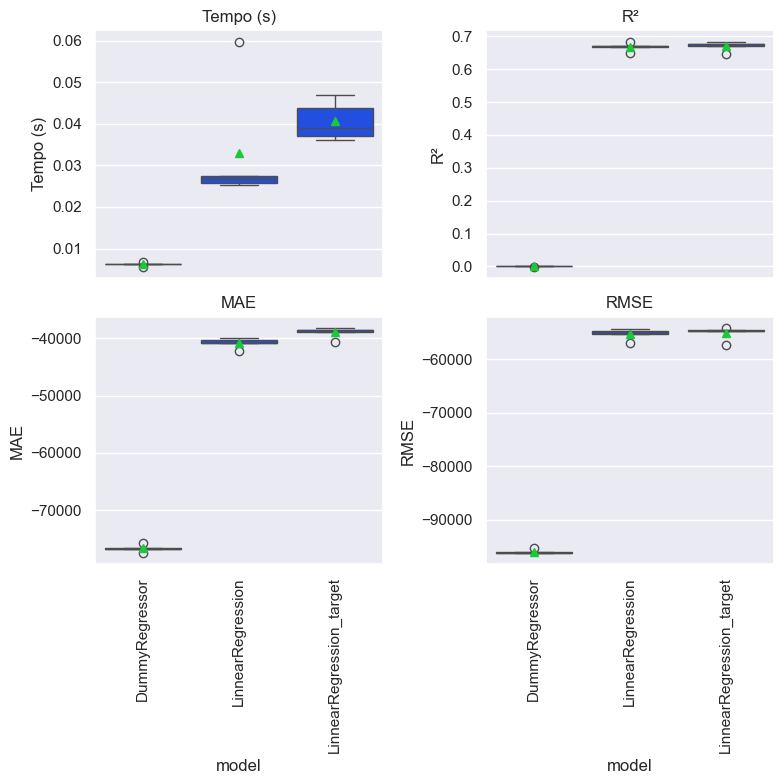

In [12]:
#o linear_regression teve um resultado melhor
plot_comparar_metricas_modelos(df_resultados)

In [15]:
param_grid = {
    'transformer':[None, PowerTransformer(), QuantileTransformer(output_distribution='normal')]
}

In [16]:
#grid_search: encontrar os melhores hiperparâmetros e transformações para o modelo de regressão.
#grid_search: find the best hyperparameters and transformations for the regression model.

grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=target_transformer,
    param_grid=param_grid,
)
grid_search    

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [17]:
grid_search.fit(X,y)   

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [18]:
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

In [19]:
grid_search.best_score_

-54416.95998871627

In [20]:
coefs=dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

In [21]:
coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.453769
remainder__longitude,-0.295755
remainder__latitude,-0.289001
remainder__population_per_household,-0.280351
one_hot__ocean_proximity_NEAR BAY,-0.202889
one_hot__ocean_proximity_NEAR OCEAN,-0.058903
remainder__total_bedrooms,-0.000232
remainder__total_rooms,-0.000060
remainder__population,-0.000037
remainder__households,0.000866


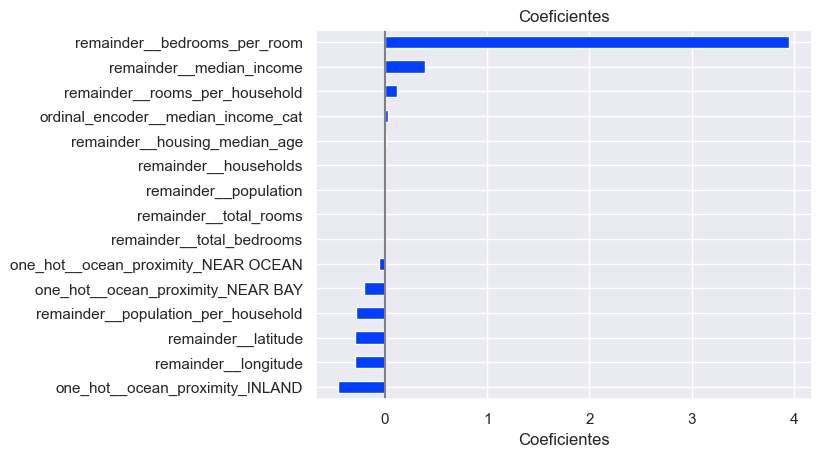

In [22]:
plot_coeficientes(coefs)

In [23]:
target_transformer = PowerTransformer()

regressors = {
    'DummyRegressor':{
        'preprocessor':None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinnearRegression':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
     'LinnearRegression_target_power':{
        'preprocessor':preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer,
    },
    'LinnearRegression_target_power_quantile':{
        'preprocessor':grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer':grid_search.best_estimator_.transformer,
    },
}    
resultados= {
    nome_modelo: treinar_e_validar_modelo_regressao(X,y,**regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002855,0.00561,-0.000081,-77516.042766,-96239.705692,0.008465
1,DummyRegressor,0.003076,0.003315,-0.000146,-75787.787194,-95217.629397,0.006391
2,DummyRegressor,0.003124,0.004649,-0.001737,-76753.598961,-96253.253947,0.007773
3,DummyRegressor,0.003376,0.004981,-0.000101,-76837.804811,-95983.885799,0.008356
4,DummyRegressor,0.003989,0.007487,-0.000114,-76617.245449,-96182.764729,0.011476
5,LinnearRegression,0.030667,0.013165,0.682162,-39855.690921,-54254.958115,0.043832
6,LinnearRegression,0.030154,0.012221,0.66999,-40272.565406,-54695.230224,0.042375
7,LinnearRegression,0.031842,0.014061,0.649247,-42178.059246,-56955.988686,0.045903
8,LinnearRegression,0.029655,0.014465,0.669873,-40806.492452,-55146.31876,0.044119
9,LinnearRegression,0.025674,0.014756,0.669023,-40788.496555,-55331.351171,0.04043


In [24]:
df_resultados.groupby('model').mean()


,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003284,0.005208,-0.000436,-76702.495836,-95975.447913,0.008492
LinnearRegression,0.029598,0.013734,0.668059,-40780.260916,-55276.769391,0.043332
LinnearRegression_target_power,0.0556,0.01236,0.671185,-38909.258354,-55011.704371,0.067959
LinnearRegression_target_power_quantile,0.039827,0.012871,0.678212,-38673.406227,-54420.653662,0.052697


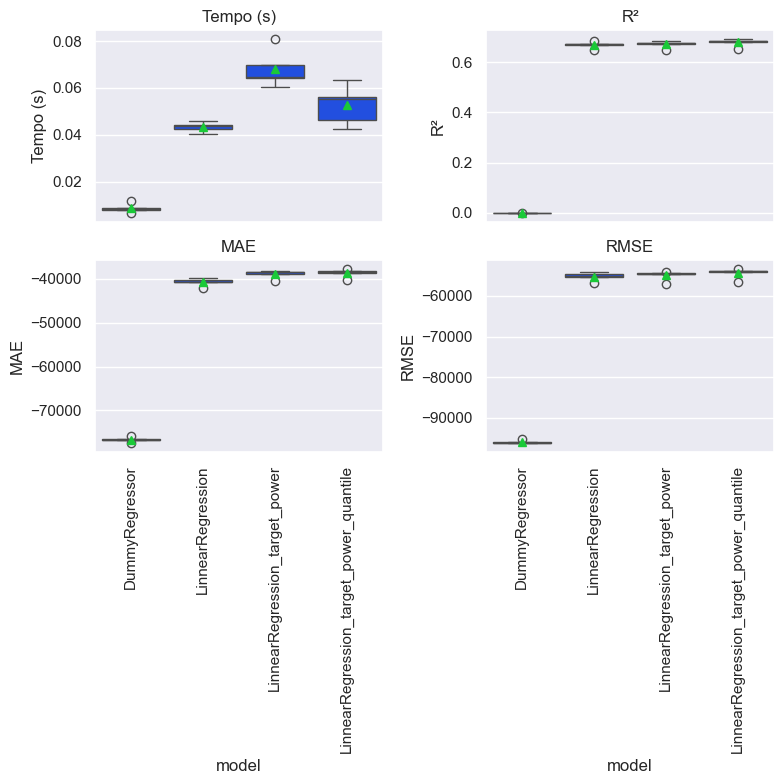

In [25]:
#o linear_regression teve um resultado melhor
plot_comparar_metricas_modelos(df_resultados)

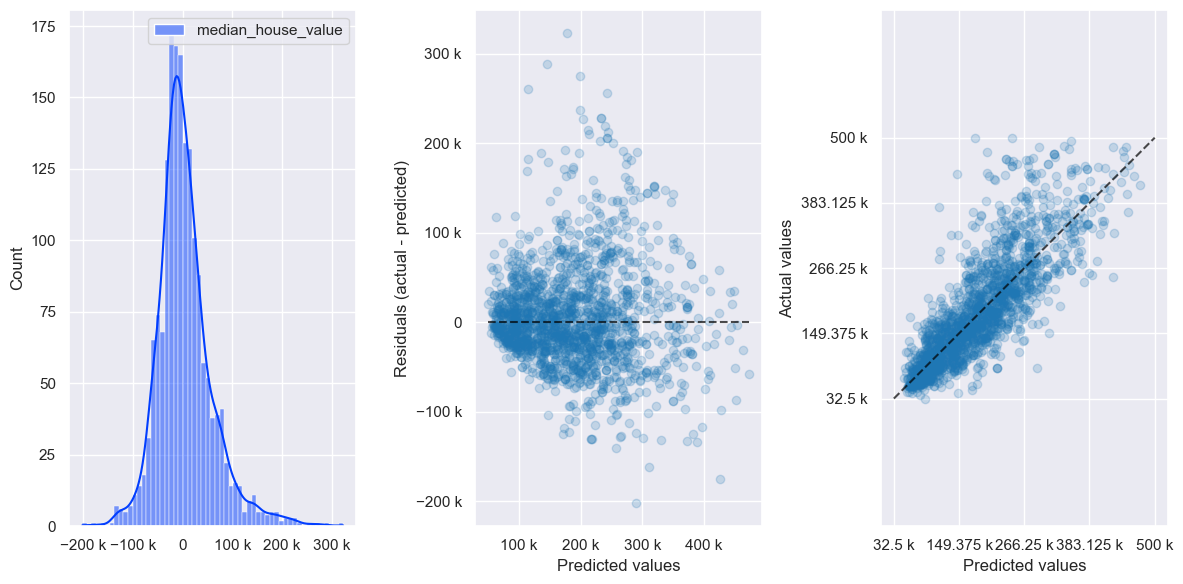

In [26]:
#avaliar a qualidade de um modelo de regressão
#evaluate the quality of a regression model

plot_residuos_estimador(grid_search.best_estimator_, X,y, fracao_amostra=0.1, eng_formatter=True)

Conclusão: 

Modelos lineares, como a LinearRegression, assumem que os resíduos são normalmente distribuídos. Se a variável target não segue uma distribuição normal, o desempenho do modelo pode ser prejudicado.

O PowerTransformer ajuda a corrigir assimetrias (skewness) e outliers, melhorando a performance do modelo.
Na análise inicial Linear models, such as LinearRegression, assume that the residuals are normally distributed. If the target variable does not follow a normal distribution, the model performance may suffer.

Já o  QuantileTransformer transforma a variável target para seguir uma distribuição uniforme ou normal, usando os quantis dos dados.
Ele é robusto a outliers e pode lidar melhor com distribuições complexas ou multimodais. Quando configurado com output_distribution='normal', ele força a variável target a seguir uma distribuição normal, o que é ideal para modelos lineares.

Por que eles foram as melhores opções?
Melhoria na distribuição da variável target:

Ambas as transformações (PowerTransformer e QuantileTransformer) ajudaram a tornar a distribuição da variável target mais adequada para modelos lineares, resultando em um melhor ajuste e menores erros.

Impacto nas métricas:

O LinearRegression_target_power e o LinearRegression_target_power_quantile tiveram um R² maior e um RMSE menor que o LinearRegression sem transformação, mostrando que as transformações foram eficazes.

Flexibilidade:

O QuantileTransformer é particularmente útil quando a variável target tem uma distribuição complexa ou outliers, enquanto o PowerTransformer é mais simples e eficaz para corrigir assimetrias.

Conclusion:

Linear models, such as LinearRegression, assume that the residuals are normally distributed. If the target variable does not follow a normal distribution, the model performance may suffer.

PowerTransformer helps correct skewness and outliers, improving the model performance.

In the initial analysis, Linear models, such as LinearRegression, assume that the residuals are normally distributed. If the target variable does not follow a normal distribution, the model performance may suffer.

QuantileTransformer transforms the target variable to follow a uniform or normal distribution, using the quantiles of the data.
It is robust to outliers and can better handle complex or multimodal distributions. When configured with output_distribution='normal', it forces the target variable to follow a normal distribution, which is ideal for linear models.

Why were they the best options?
Improved target variable distribution:

Both transformations (PowerTransformer and QuantileTransformer) helped to make the target variable distribution more suitable for linear models, resulting in a better fit and lower errors.

Impact on metrics:

LinearRegression_target_power and LinearRegression_target_power_quantile had a higher R² and a lower RMSE than LinearRegression without transformation, showing that the transformations were effective.

Flexibility:

QuantileTransformer is particularly useful when the target variable has a complex distribution or outliers, while PowerTransformer is simpler and more effective for correcting asymmetries.

